# Data upload

In [4]:
import warnings
warnings.filterwarnings("ignore")

import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gzip
import statsmodels.api as sm
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

import sys
# Append to path the directory where the src folder is located
repo_path = '/root/ADA2023/ada-2023-project-adacadabra2023/ada-2023-project-adacadabra2023'
sys.path.append(repo_path)
import src.data.Preprocessing as pproc 
import src.data.HerdingFunctions as hf
import src.data.Text_preprocessing as txt_pproc

# 
directory = repo_path#os.getcwd()
data_path = os.path.join(directory, 'Data')

# Definining the path for the files
RB_path = os.path.join(data_path, 'RateBeer')
BA_path = os.path.join(data_path, 'BeerAdvocate')
MB_path = os.path.join(data_path, 'matched_beer_data')

# Extraction of the data and preprocessing of the files

In [5]:
# Extraction of the .tar files
pproc.extract_tar_files(data_path)

In [6]:
#Transformation of the .txt files
pproc.text_to_tsv(RB_path, 'ratings')
pproc.text_to_tsv(RB_path, 'reviews')

pproc.text_to_tsv(BA_path, 'ratings')
pproc.text_to_tsv(BA_path, 'reviews')

pproc.text_to_tsv(MB_path, 'ratings_ba')
pproc.text_to_tsv(MB_path, 'ratings_with_text_ba')
pproc.text_to_tsv(MB_path, 'ratings_rb')
pproc.text_to_tsv(MB_path, 'ratings_with_text_rb')

KeyboardInterrupt: 

# Creation of dataframes

Matching data:

In [2]:
MB_beers = pd.read_csv(MB_path + '/beers.csv', header=1)
MB_breweries = pd.read_csv(MB_path + '/breweries.csv', header=1)
MB_users = pd.read_csv(MB_path + '/users.csv', header=1)
MB_users_approx = pd.read_csv(MB_path + '/users_approx.csv', header=1)

In [3]:
MB_ratings = pd.read_csv(MB_path + '/ratings.csv', header=1)
MB_ratingsBA = pd.read_csv(MB_path + '/ratings_ba.tsv', sep='\t')
MB_ratingsBA_txt = pd.read_csv(MB_path + '/ratings_with_text_ba.tsv', sep='\t')
MB_ratingsRB = pd.read_csv(MB_path + '/ratings_rb.tsv', sep='\t')
MB_ratingsRB_txt = pd.read_csv(MB_path + '/ratings_with_text_rb.tsv', sep='\t')

In [ ]:
RB_beers = pd.read_csv(RB_path + '/beers.csv')
RB_breweries = pd.read_csv(RB_path + '/breweries.csv')
RB_users = pd.read_csv(RB_path + '/users.csv')
RB_ratings = pd.read_csv(RB_path + '/ratings.tsv', sep='\t')
RB_reviews = pd.read_csv(RB_path + '/reviews.tsv', sep='\t')

In [ ]:
BA_beers = pd.read_csv(BA_path + '/beers.csv')
BA_breweries = pd.read_csv(BA_path + '/breweries.csv')
BA_users = pd.read_csv(BA_path + '/users.csv')
BA_ratings = pd.read_csv(BA_path + '/ratings.tsv', sep='\t')
BA_reviews = pd.read_csv(BA_path + '/reviews.tsv', sep='\t')

# Define filtration parameters:

In [5]:
RB_ratings = pd.read_csv(RB_path + '/ratings.tsv', sep='\t')
RB_ratings.shape

(7122074, 16)

In [6]:
BA_ratings = pd.read_csv(BA_path + '/ratings.tsv', sep='\t')
BA_ratings.shape

(8393032, 17)

In [7]:
BA_users = pd.read_csv(BA_path + '/users.csv')
RB_users = pd.read_csv(RB_path + '/users.csv')


Text(0.5, 0, 'Number of ratings (RB)')

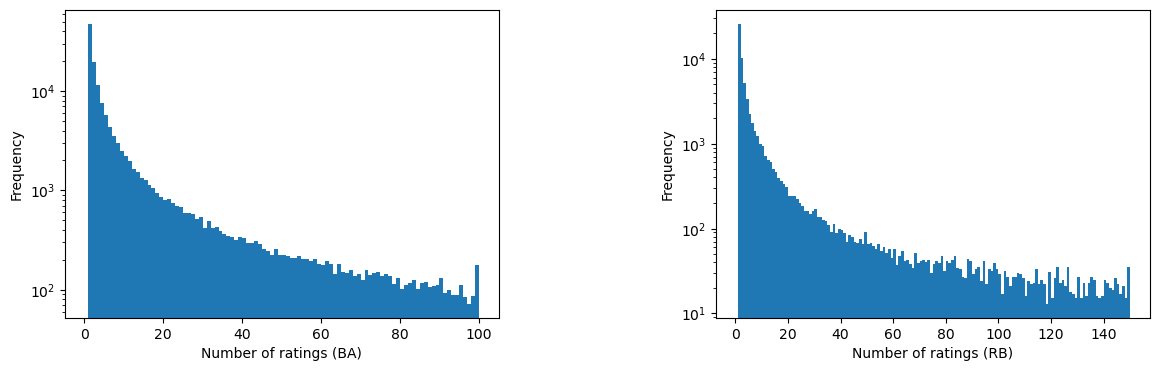

In [8]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

BA_users['nbr_ratings'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[0], logy=True)
axs[0].set_xlabel('Number of ratings (BA)')
RB_users['nbr_ratings'].sort_values().plot(kind='hist', range = (0, 150), bins= 150, ax=axs[1], logy=True)
axs[1].set_xlabel('Number of ratings (RB)')

In [9]:
BA_beers = pd.read_csv(BA_path + '/beers.csv')
RB_beers = pd.read_csv(RB_path + '/beers.csv')

Text(0.5, 0, 'Number of ratings per beer (RB)')

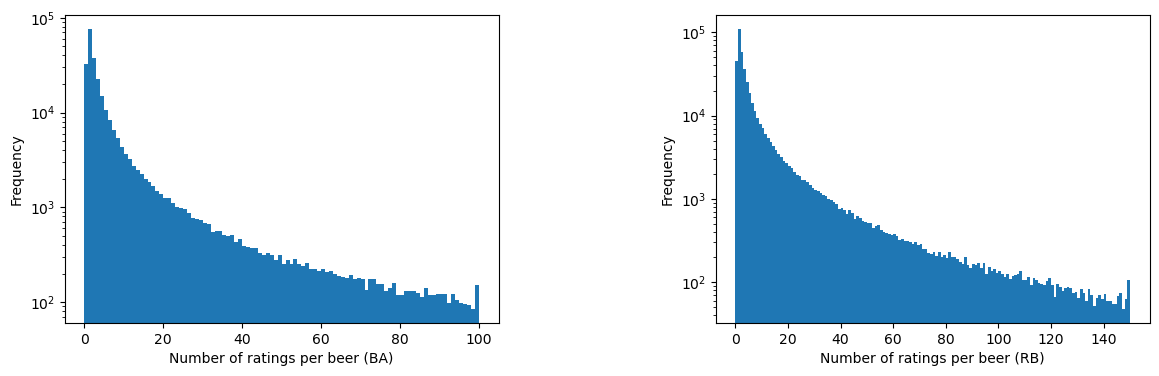

: 

In [10]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

BA_beers['nbr_ratings'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[0], logy=True)
axs[0].set_xlabel('Number of ratings per beer (BA)')
RB_beers['nbr_ratings'].sort_values().plot(kind='hist', range = (0, 150), bins= 150, ax=axs[1], logy=True)
axs[1].set_xlabel('Number of ratings per beer (RB)')

## Unification of dataframes

In [24]:
# Creation of the df with ALL the breweries with a unique brewery ID (chosen to be the one from RB)
unified_breweries = RB_breweries
unified_breweries = unified_breweries.rename(columns={'nbr_beers':'nbr_beers_rb'})

BA_brew = BA_breweries.add_suffix('_ba')

MB_breweries_subset = MB_breweries[['id', 'id.1', 'location', 'location.1', 'nbr_beers', 'nbr_beers.1', 'name', 'name.1']]
MB_breweries_subset = MB_breweries_subset.add_suffix('_ba')
MB_breweries_subset.columns = MB_breweries_subset.columns.str.replace('.1_ba' , '_rb')

merged_df = pd.merge(BA_brew, MB_breweries_subset, on=['id_ba', 'name_ba', 'location_ba', 'nbr_beers_ba'], how='left')
available_numbers_brew = np.setxor1d(np.arange(1,3*len(BA_brew)), unified_breweries.id.unique())
merged_df['new_ba_brew_id'] = available_numbers_brew[:len(BA_brew)]

merged_df['id'] = merged_df['id_rb'].combine_first(merged_df['new_ba_brew_id'])
merged_df['location'] = merged_df['location_rb'].combine_first(merged_df['location_ba'])
merged_df['name'] = merged_df['name_rb'].combine_first(merged_df['name_ba'])

unified_breweries = unified_breweries.merge(merged_df[['name', 'id', 'location', 'nbr_beers_ba']], on=['id', 'name', 'location'], how='outer')
unified_breweries['nbr_beers_rb'].fillna(0, inplace=True)
unified_breweries['nbr_beers_ba'].fillna(0, inplace=True)
unified_breweries['total_nbr_beers'] = unified_breweries[["nbr_beers_rb", "nbr_beers_ba"]].max(axis=1)

# Duplicated in the BA database
unified_breweries['nbr_ba'] = unified_breweries.groupby('id')['nbr_beers_ba'].transform('mean')
unified_breweries = unified_breweries.drop_duplicates('id')
unified_breweries = unified_breweries.drop('nbr_beers_ba', axis=1)
unified_breweries = unified_breweries.rename(columns={'nbr_ba':'nbr_beers_ba'})
display(unified_breweries)

,id,location,name,nbr_beers_rb,total_nbr_beers,nbr_beers_ba
0,3198.0,Gabon,Sobraga,3.0,3.0,0.0
1,13538.0,Northern Ireland,Ards Brewing Co.,13.0,13.0,7.0
2,22304.0,Northern Ireland,Barrahooley Craft Brewery,4.0,4.0,3.0
3,22818.0,Northern Ireland,Boundary,66.0,66.0,0.0
4,24297.0,Northern Ireland,Brewbot Belfast,3.0,3.0,0.0
...,...,...,...,...,...,...
32707,40943.0,Germany,Privatbrauerei Franz Joseph Sailer,0.0,6.0,6.0
32708,40944.0,Aruba,Aruba Brewing,0.0,0.0,0.0
32709,40945.0,"United States, New York",John Harvard’s Brewery & Ale House,0.0,491.0,491.0
32710,40946.0,"United States, North Carolina",Triangle Brewing Company,0.0,20.0,20.0


In [25]:
# Creation of the df with ALL the beers (that have at least one rating) with a unique beer ID (randomly chosen to be the 
# one from RB)

unified_beers = RB_beers[['beer_id', 'beer_name', 'nbr_ratings', 'style', 'brewery_id', 'brewery_name']]
unified_beers = unified_beers.rename(columns={'nbr_ratings':'nbr_ratings_rb'})

BA_beers_subset = BA_beers[['beer_id', 'beer_name', 'nbr_ratings', 'style', 'brewery_id', 'brewery_name']]
BA_beers_subset.columns += '_ba'

MB_beers_subset = MB_beers[['beer_id', 'beer_id.1', 'beer_name', 'beer_name.1', 'style', 'style.1', 'brewery_id', 'brewery_id.1', 'brewery_name', 'brewery_name.1']]
MB_beers_subset.columns += '_ba'
MB_beers_subset.columns = MB_beers_subset.columns.str.replace('.1_ba' , '_rb')

merged_df_beers = pd.merge(BA_beers_subset, MB_beers_subset, on=['beer_id_ba', 'beer_name_ba', 'style_ba', 'brewery_id_ba', 'brewery_name_ba'], how='left')
available_numbers = np.setxor1d(np.arange(1,3*len(BA_beers_subset)), unified_beers.beer_id.unique())
merged_df_beers['new_ba_id'] = available_numbers[:len(BA_beers_subset)]
merged_df_beers['brewery_name'] = merged_df_beers['brewery_name_rb'].combine_first(merged_df_beers['brewery_name_ba'])
equivalences_dict_brew_id = dict(zip(unified_breweries['name'], unified_breweries['id']))
merged_df_beers['brewery_id'] = merged_df_beers['brewery_name'].map(equivalences_dict_brew_id)
merged_df_beers['style'] = merged_df_beers['style_rb'].combine_first(merged_df_beers['style_ba'])
merged_df_beers['beer_id'] = merged_df_beers['beer_id_rb'].combine_first(merged_df_beers['new_ba_id'])
merged_df_beers['beer_name'] = merged_df_beers['beer_name_rb'].combine_first(merged_df_beers['beer_name_ba'])

unified_beers = unified_beers.merge(merged_df_beers[['nbr_ratings_ba', 'style', 'brewery_id', 'brewery_name', 'beer_id', 'beer_name']], on=['beer_id', 'beer_name', 'brewery_id', 'brewery_name','style'], how='outer')
unified_beers['nbr_ratings_rb'].fillna(0, inplace=True)
unified_beers['nbr_ratings_ba'].fillna(0, inplace=True)
unified_beers['total_nbr_ratings'] = unified_beers['nbr_ratings_rb'] + unified_beers['nbr_ratings_ba']

# The duplicates here come from breweries that have different IDs because they have a different location although the same name
display(unified_beers)

,beer_id,beer_name,nbr_ratings_rb,style,brewery_id,brewery_name,nbr_ratings_ba,total_nbr_ratings
0,410549.0,33 Export (Gabon),1.0,Pale Lager,3198.0,Sobraga,0.0,1.0
1,105273.0,Castel Beer (Gabon),10.0,Pale Lager,3198.0,Sobraga,0.0,10.0
2,19445.0,Régab,27.0,Pale Lager,3198.0,Sobraga,0.0,27.0
3,155699.0,Ards Bally Black Stout,6.0,Stout,13538.0,Ards Brewing Co.,0.0,6.0
4,239097.0,Ards Belfast 366,1.0,Golden Ale/Blond Ale,13538.0,Ards Brewing Co.,0.0,1.0
...,...,...,...,...,...,...,...,...
677310,722900.0,Kölsch Ale,0.0,Kölsch,346.0,Summit Station Restaurant & Brewery,3.0,3.0
677311,722901.0,Nut Brown Ale,0.0,English Brown Ale,346.0,Summit Station Restaurant & Brewery,2.0,2.0
677312,722902.0,Octoberfest,0.0,Märzen / Oktoberfest,346.0,Summit Station Restaurant & Brewery,0.0,0.0
677313,722903.0,Scotch Ale,0.0,Scotch Ale / Wee Heavy,346.0,Summit Station Restaurant & Brewery,0.0,0.0


In [26]:
# Creation of the df with ALL the users with a unique user ID (randomly chosen to be the one from RB)
unified_users = RB_users[['nbr_ratings', 'user_id', 'user_name', 'location']]
unified_users = unified_users.rename(columns={'nbr_ratings':'nbr_ratings_rb'})

BA_users_subset = BA_users[['nbr_ratings', 'user_id', 'user_name', 'location']]
BA_users_subset = BA_users_subset.add_suffix('_ba')

MB_users_subset = MB_users[['location', 'location.1', 'nbr_ratings', 'nbr_ratings.1', 'user_id', 'user_id.1', 'user_name', 'user_name.1']]
MB_users_subset = MB_users_subset.add_suffix('_ba')
MB_users_subset.columns = MB_users_subset.columns.str.replace('.1_ba' , '_rb')

merged_df_users = pd.merge(BA_users_subset, MB_users_subset, on=['user_id_ba', 'user_name_ba', 'location_ba', 'nbr_ratings_ba'], how='left')
available_numbers = np.setxor1d(np.arange(1,3*len(BA_users_subset)), unified_users.user_id.unique())
merged_df_users['new_ba_id'] = available_numbers[:len(BA_users_subset)]

merged_df_users['user_name'] = merged_df_users['user_name_rb'].combine_first(merged_df_users['user_name_ba'])
merged_df_users['location'] = merged_df_users['location_rb'].combine_first(merged_df_users['location_ba'])
merged_df_users['user_id'] = merged_df_users['user_id_rb'].combine_first(merged_df_users['new_ba_id'])

unified_users = unified_users.merge(merged_df_users[['nbr_ratings_ba', 'user_name', 'location', 'user_id']], on=['user_id', 'user_name', 'location'], how='outer')
unified_users['nbr_ratings_rb'].fillna(0, inplace=True)
unified_users['nbr_ratings_ba'].fillna(0, inplace=True)
unified_users['total_nbr_ratings'] = unified_users['nbr_ratings_rb'] + unified_users['nbr_ratings_ba']
display(unified_users)

,nbr_ratings_rb,user_id,user_name,location,nbr_ratings_ba,total_nbr_ratings
0,1890.0,175852.0,Manslow,Poland,0.0,1890.0
1,89.0,442761.0,MAGICuenca91,Spain,0.0,89.0
2,169.0,288889.0,Sibarh,Poland,0.0,169.0
3,3371.0,250510.0,fombe89,Spain,0.0,3371.0
4,13043.0,122778.0,kevnic2008,Germany,0.0,13043.0
...,...,...,...,...,...,...
220853,0.0,188321.0,Everman,"United States, California",1.0,1.0
220854,0.0,188322.0,Justin0001,"United States, California",1.0,1.0
220855,0.0,188323.0,Kyungsup,NaN,1.0,1.0
220856,0.0,188324.0,JoeTex,"United States, California",1.0,1.0


In [27]:
# Creation of the df with ALL the ratings with a unique user ID (randomly chosen to be the one from RB)
unified_ratings = RB_ratings[['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'date', 'rating', 'user_id']] #'text', 'user_id']]
unified_ratings['Procedence'] = 'RB'

BA_subset = BA_ratings[['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'date', 'rating', 'user_id']] #'text', 'user_id']]
BA_subset = BA_subset.add_suffix('_ba')

equivalences_brew_id = dict(zip(merged_df['id_ba'], merged_df['id']))
BA_subset['brewery_id'] = BA_subset['brewery_id_ba'].map(equivalences_brew_id)

BA_subset['brewery_name_ba'] = BA_subset['brewery_name_ba'].str.strip()
equivalences_brew_name = dict(zip(merged_df['name_ba'].str.strip(), merged_df['name']))
BA_subset['brewery_name'] = BA_subset['brewery_name_ba'].map(equivalences_brew_name)

equivalences_beer_id = dict(zip(merged_df_beers['beer_id_ba'], merged_df_beers['beer_id']))
BA_subset['beer_id'] = BA_subset['beer_id_ba'].map(equivalences_beer_id)

equivalences_user_id = dict(zip(merged_df_users['user_id_ba'].str.strip(), merged_df_users['user_id']))
BA_subset['user_id_ba'] = BA_subset['user_id_ba'].str.strip()
BA_subset['user_id'] = BA_subset['user_id_ba'].map(equivalences_user_id)

BA_subset['beer_name_ba'] = BA_subset['beer_name_ba'].str.strip()
equivalences_beer_name = dict(zip(merged_df_beers['beer_name_ba'].str.strip(), merged_df_beers['beer_name']))
BA_subset['beer_name'] = BA_subset['beer_name_ba'].map(equivalences_beer_name)

BA_subset['style_ba'] = BA_subset['style_ba'].str.strip()
equivalences_style = dict(zip(merged_df_beers['style_ba'].str.strip(), merged_df_beers['style']))
BA_subset['style'] = BA_subset['style_ba'].map(equivalences_style)

BA_subset = BA_subset.drop(['beer_name_ba', 'beer_id_ba', 'brewery_id_ba', 'brewery_name_ba', 'style_ba', 'user_id_ba'], axis=1)
BA_subset.columns = BA_subset.columns.str.replace('_ba' , '')
BA_subset['Procedence'] = 'BA'

unified_ratings = pd.concat([unified_ratings, BA_subset], ignore_index=True)

equivalences_country = dict(zip(unified_users['user_id'], unified_users['location']))
unified_ratings['country_user'] = unified_ratings['user_id'].map(equivalences_country)

equivalences_brew_country = dict(zip(unified_breweries['id'], unified_breweries['location']))
unified_ratings['country_brewery'] = unified_ratings['brewery_id'].map(equivalences_brew_country)

display(unified_ratings)

,beer_name,beer_id,brewery_name,brewery_id,style,date,rating,user_id,Procedence,country_user,country_brewery
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,1461664800,2.00,175852.0,RB,Poland,Gabon
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,1487329200,1.90,442761.0,RB,Spain,Gabon
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,1466762400,1.60,288889.0,RB,Poland,Gabon
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,1451646000,1.50,250510.0,RB,Spain,Gabon
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,1445594400,1.90,122778.0,RB,Germany,Gabon
...,...,...,...,...,...,...,...,...,...,...,...
15515101,Kölsch Ale,722900.0,Summit Station Restaurant & Brewery,346.0,Kölsch,1141038000,3.80,13464.0,BA,"United States, Connecticut","United States, Maryland"
15515102,Kölsch Ale,722900.0,Summit Station Restaurant & Brewery,346.0,Kölsch,1140346800,2.80,1143.0,BA,"United States, Maryland","United States, Maryland"
15515103,Kölsch Ale,722900.0,Summit Station Restaurant & Brewery,346.0,Kölsch,1092132000,1.54,6811.0,BA,"United States, Virginia","United States, Maryland"
15515104,Nut Brown Ale,722901.0,Summit Station Restaurant & Brewery,346.0,English Brown Ale,1341741600,3.50,39556.0,BA,NaN,"United States, Maryland"


## Expertise analysis

In [26]:
#We sort the values descending in log scale, where the first value has the highest number of ratings 
#And the last ones have one review
users_copy = pd.DataFrame( unified_users.total_nbr_ratings.sort_values(ascending = False).values, columns= ['counts'])
cumulative_df = pd.DataFrame( users_copy.cumsum().values, columns= ['counts'])
cumulative_df = cumulative_df/users_copy['counts'].sum()

#Number of users and the median value
interval = np.arange(0, len(users_copy), 1)
median_value = users_copy['counts'].median()
median_position = int(len(users_copy['counts'])/2)

Text(0, 0.5, 'Number of ratings')

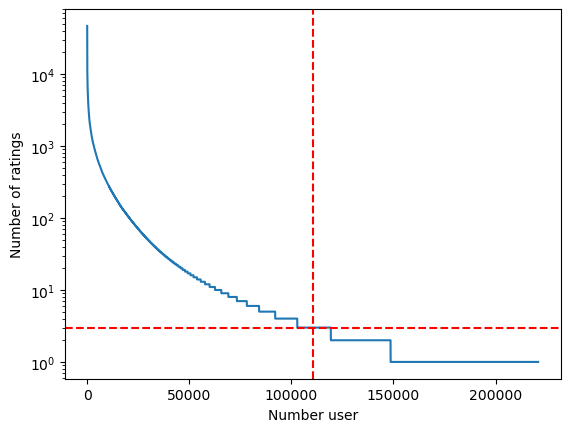

In [27]:
plt.plot(interval, users_copy['counts'])
plt.yscale('log')
plt.axhline(y = median_value, color = 'red', linestyle = '--')
plt.axvline(x = median_position, color = 'red', linestyle = '--')

plt.xlabel('Number user')
plt.ylabel('Number of ratings')


Where we can see that the distribution is very skewed: 
- Low number of users had given high number of ratings
- The majority of the users, writes low reviews

5.357741173061424 % of users represents the 80% of the reviews 


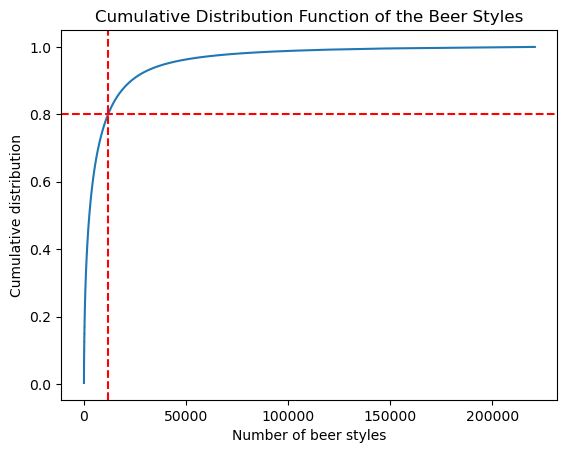

In [28]:
#Case for representing the 80% of the total reviews
df = cumulative_df.loc[cumulative_df['counts'] >= 0.8]
x_value = cumulative_df.loc[cumulative_df['counts'] >= 0.8].index[0]

plt.step(cumulative_df.index.values, cumulative_df['counts'])
plt.xlabel('Number of beer styles')
plt.ylabel('Cumulative distribution')
plt.title('Cumulative Distribution Function of the Beer Styles')


plt.axhline(y = 0.8, color = 'red', linestyle = '--')
plt.axvline(x = x_value, color = 'red', linestyle = '--')

N = len(users_copy['counts'])
ratio = 100 * x_value / N
print(f'{ ratio } % of users represents the 80% of the reviews ')

In [29]:
users_copy.iloc[x_value]

counts    239.0
Name: 11833, dtype: float64

We can see that among the total reviews, 80% is written by 5% of the users, which gave more than 239 reviews in total. 
Considering that consistent data is from 2000, during around 20 years, experts gave at least 1 review per month. Which even if this number is relatevely high, we hypothesize that experts may write more reviews.

Therefore we find what should be the ideal threshold for being able to separate the population between experts and non-experts.
This by minimizing the t-test value.


In [30]:
# fig, axs = plt.subplots(100,2, figsize = (15,10))
table = []
result = []

for i in range(1, 10000):
    division_min = users_copy[users_copy['counts'] <= i]
    division_max = users_copy[users_copy['counts' ] > i]

    test = sm.stats.ttest_ind(division_min['counts'], division_max['counts'])
    result.append(test[0])


    table.append([np.mean(division_min['counts']), np.std(division_min['counts']), np.mean(division_max['counts']), np.std(division_max['counts'])])

The threshold that throws the lowest T value is: 3352


Text(0, 0.5, 'Ttest value')

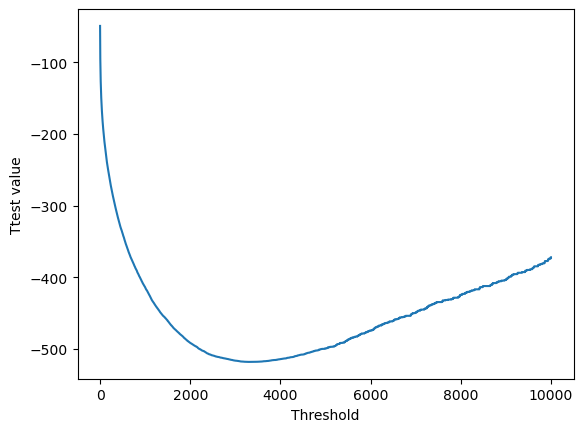

In [31]:
min_value = np.nanmin(result)
print(f'The threshold that throws the lowest T value is: {result.index(min_value)}')

plt.plot(result)
plt.xlabel('Threshold')
plt.ylabel('Ttest value')

In [32]:
percentage_experts = len(users_copy[users_copy['counts'] >= 3352].values)/ N

print(f'The percentage of experts aomng the users is: {percentage_experts*100} %')

The percentage of experts aomng the users is: 0.29204285106267375 %


In [34]:
cumulative_df.iloc[644]

counts    0.267694
Name: 644, dtype: float64

In [20]:
users_copy['expertise'] = (users_copy['counts'] >= 3352)

Text(0, 0.5, 'Number of users')

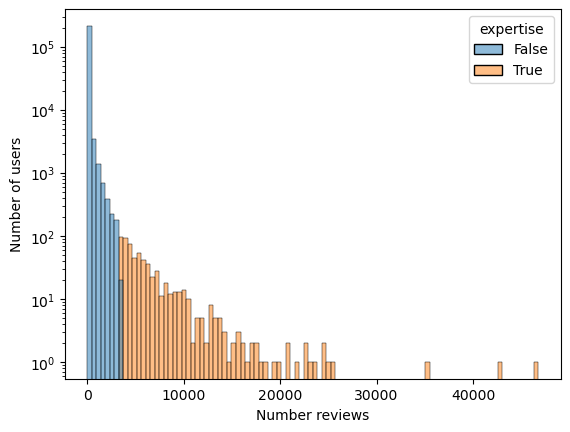

In [21]:
sns.histplot(data = users_copy, x= 'counts', hue = 'expertise', log_scale= (False, True), bins = 100)
plt.xlabel('Number reviews')
plt.ylabel('Number of users')

In [17]:
unified_users['expertise'] = (unified_users['total_nbr_ratings'] >= 3352).astype(int)
unified_users

,nbr_ratings_rb,user_id,user_name,location,nbr_ratings_ba,total_nbr_ratings,expertise
0,1890.0,175852.0,Manslow,Poland,0.0,1890.0,0
1,89.0,442761.0,MAGICuenca91,Spain,0.0,89.0,0
2,169.0,288889.0,Sibarh,Poland,0.0,169.0,0
3,3371.0,250510.0,fombe89,Spain,0.0,3371.0,1
4,13043.0,122778.0,kevnic2008,Germany,0.0,13043.0,1
...,...,...,...,...,...,...,...
220853,0.0,188321.0,Everman,"United States, California",1.0,1.0,0
220854,0.0,188322.0,Justin0001,"United States, California",1.0,1.0,0
220855,0.0,188323.0,Kyungsup,NaN,1.0,1.0,0
220856,0.0,188324.0,JoeTex,"United States, California",1.0,1.0,0


# Minimization of the herding effect in the z-score

For our analysis, we will be using the matched dataset since, although we are not considering a comparison between BeerAdvocate and RateBeer but using the data globally, the herding effect needs to be corrected for each of the databases separately. According to the article by G. Lederrey and R. West (https://doi.org/10.1145/3178876.3186160), the matched set has gone through internal and external validity in terms of being unbiased with respect to countries and beer style distributions and rating being "approximately independent of site and product properties".

However, in order to analyze the top ranked beers for each year or merge scores and ratings from both sources, we would need to consider the herding effect. In other words, if for a certain year there is a larger number of ratings coming from the database that has being positively impacted by the herding effect, the average in rating will be higher than in the opposite case. One could consider that this effect would be mitigated by doing a macro-average but sometimes this is not the goal we are looking for and, if for a certain year, for example, we only have beers coming from the same source, the herding effect would still be present.

Also important to note is that the herding effect, although continuing to be present, has a lower effect when the number of ratings for the beer is higher. It becomes approximately a stable value after the 5th rating. 

In [28]:
# Addition of a time column in an interpretable format. Also, addition of a 'year' column.
unified_ratings = hf.correct_time(unified_ratings, season=True).copy(deep=True)

For each of the merged ratings, we will get the z-score from the original dataframe. Note that this rating score was transformed to z-score following the protocol described in the cited paper (https://doi.org/10.1145/3178876.3186160). Then, a linear regression model was fitted for each type of beer, modelling the difference between the z-score for the ith rating and the expanding average until that point. This was then detrended from the z-score value and added as an additional column ('detrend').

In [29]:
unified_ratings['z_score'] = unified_ratings.groupby(['Procedence', 'year'])['rating'].transform(lambda x:(x-x.mean())/x.std())

In [30]:
unified_ratings_BA = unified_ratings[unified_ratings.Procedence == 'BA']
unified_ratings_RB = unified_ratings[unified_ratings.Procedence == 'RB']
unified_ratings_BA = hf.he_correction(unified_ratings_BA)
unified_ratings_RB = hf.he_correction(unified_ratings_RB)

unified_ratings = pd.concat([unified_ratings_BA, unified_ratings_RB], ignore_index=True)

In [31]:
unified_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,date,rating,user_id,Procedence,country_user,country_brewery,year,Season,z_score,exp_mean,diff_exp_mean,ith_rating,detrend
0,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2003-10-15 10:00:00,3.55,11266.0,BA,"United States, Illinois","United States, Louisiana",2003,Autumn,-0.201923,-0.201923,0.000000,1,-0.032678
1,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2003-12-22 11:00:00,3.85,6816.0,BA,"United States, Massachusetts","United States, Louisiana",2003,Winter,0.228929,0.013503,0.215426,2,0.397968
2,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-04-06 10:00:00,2.90,5470.0,BA,"United States, Louisiana","United States, Louisiana",2004,Spring,-1.253651,-0.408882,-0.844769,3,-1.084818
3,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-04-22 10:00:00,2.39,5545.0,BA,"United States, Connecticut","United States, Louisiana",2004,Spring,-2.019939,-0.811646,-1.208293,4,-1.851312
4,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-05-02 10:00:00,3.28,32532.0,BA,"United States, Texas","United States, Louisiana",2004,Spring,-0.682692,-0.785855,0.103163,5,-0.514270


## 

# Popularity analysis over time

The rationale behind this idea is to be able to match or provide fun facts to the users of our social network about which would have been the perfect year for them to live in according to their preferences. Thus, we try to uncover trends in beers over the years.

We will start by analyzing the distribution of the number of ratings for each merged beer id to discard the beers with a very low number of ratings. Although the scores have been detrended, analyzing popularity involves getting consistently a high score. If we only considered the score of the beers, a beer with a single rating but maximum score could be considered as the most popular beer for a certain year and this does not seem to reflect the situation.

In [12]:
# Drop down of the unuseful columns for the time analysis
time_columns_to_keep = ['beer_id', 'beer_name','beer_id.1','beer_name.1','nbr_ratings', 'nbr_ratings.1', 'style', 'style.1','diff','sim']
time_MB_beers = MB_beers.filter(time_columns_to_keep)
time_MB_beers = time_MB_beers.rename(columns={'beer_id': 'beer_id_BA', 'beer_name': 'beer_name_BA', 'beer_id.1': 'beer_id_RB', 'beer_name.1': 'beer_name_RB', 'nbr_ratings': 'nbr_ratings_BA', 'nbr_ratings.1': 'nbr_ratings_RB', 'style': 'style_BA', 'style.1': 'style_RB'})
time_MB_beers

,beer_id_BA,beer_name_BA,beer_id_RB,beer_name_RB,nbr_ratings_BA,nbr_ratings_RB,style_BA,style_RB,diff,sim
0,19827,Legbiter,37923,Strangford Lough Legbiter,75,89,English Pale Ale,Golden Ale/Blond Ale,1.000000,1.0
1,20841,St. Patrick's Ale,41286,Strangford Lough St. Patricks Ale,8,11,English Pale Ale,Irish Ale,0.527141,1.0
2,20842,St. Patrick's Best,41287,Strangford Lough St. Patricks Best,64,74,English Bitter,Bitter,0.527141,1.0
3,22659,St. Patrick's Gold,41285,Strangford Lough St. Patricks Gold,1,4,American Pale Wheat Ale,Amber Ale,0.527141,1.0
4,178681,Sheelin Stout,230283,Sheelin Stout,0,2,Irish Dry Stout,Mild Ale,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
45635,96911,Pale Ale,242782,Do Can Pale Ale,4,1,English Pale Ale,India Pale Ale (IPA),1.000000,1.0
45636,37457,Mustang Gold Ale,68764,Warbird Mustang Gold Ale,22,57,American Blonde Ale,Golden Ale/Blond Ale,0.806680,1.0
45637,47287,Shanty Irish,76984,Warbird Shanty Irish,10,50,Irish Red Ale,Irish Ale,1.000000,1.0
45638,37177,Thunderbolt Wheat,78298,Warbird Thunderbolt Wheat,21,59,Hefeweizen,German Hefeweizen,1.000000,1.0


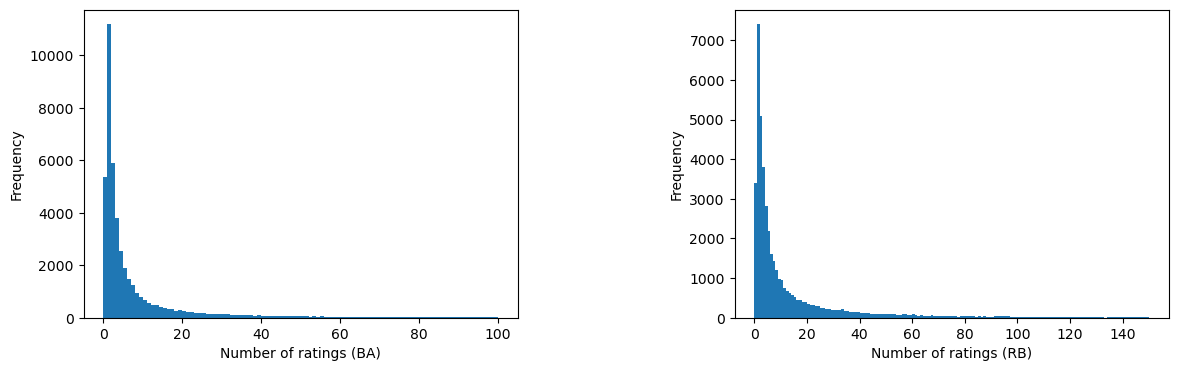

In [13]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

time_MB_beers['nbr_ratings_BA'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[0])
axs[0].set_xlabel('Number of ratings (BA)')
time_MB_beers['nbr_ratings_RB'].sort_values().plot(kind='hist', range = (0, 150), bins= 150, ax=axs[1])
axs[1].set_xlabel('Number of ratings (RB)')

plt.show()

In [14]:
time_MB_beers.nbr_ratings_BA.describe()

count    45640.000000
mean        20.945837
std        137.768038
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       9228.000000
Name: nbr_ratings_BA, dtype: float64

In [15]:
time_MB_beers.nbr_ratings_RB.describe()

count    45640.000000
mean        22.362796
std         80.107455
min          0.000000
25%          2.000000
50%          5.000000
75%         16.000000
max       5272.000000
Name: nbr_ratings_RB, dtype: float64

Seeing this basic statistics and having observed the histograms we will filter out so that we keep beers with at least 5 ratings for both of the datasets (columns 'nbr_ratings_BA' and 'nbr_ratings_RB'). This will later help us in dimishing the **herding effect** and in assessing popularity by having a consistently high score (and not a high score once).

Fig. 6 in the previously mentioned paper, shows that the herding effect, although never converging to 0, becomes stable with a larger number of ratings with respect to the first one. Thus, we will keep the beers with at least 5 ratings. Note that 5 is the median value of the number of ratings in RateBeer but, in the case of BearAdvocate, it is below it. However, discarding these samples still leaves us with approximately 30% of the data which is a large amount of data (12890 beers).

In [16]:
time_filt_MB_beers = time_MB_beers[(time_MB_beers['nbr_ratings_BA'] >= 5) & (time_MB_beers['nbr_ratings_RB'] >= 5)].copy(deep=True) 

### Macro-averages

In [17]:
# Based on the keep beers (with more than 5 ratings in each source), we will select all the available ratings
beer_id_BA = time_filt_MB_beers.beer_id_BA.to_numpy()
beer_id_RB = time_filt_MB_beers.beer_id_RB.to_numpy()

time_ratings_BA = MB_ratings_BA[MB_ratings_BA['beer_id'].isin(beer_id_BA)].copy(deep=True)
time_ratings_RB = MB_ratings_RB[MB_ratings_RB['beer_id'].isin(beer_id_RB)].copy(deep=True)

In [18]:
# Mean for each beer in each year
avgBA = time_ratings_BA.groupby(['year', 'beer_id'])['detrend'].mean()
avgRB = time_ratings_RB.groupby(['year', 'beer_id'])['detrend'].mean()

In [19]:
# Creation of a dataframe with the results (this also implies matching in the beer ID which is NOT the same for BA and RB)
avgBA_df = avgBA.reset_index()
avgBA_df = avgBA_df.rename(columns={'detrend': 'detrend_BA', 'beer_id': 'beer_id_BA'})
avgRB_df = avgRB.reset_index()
avgRB_df = avgRB_df.rename(columns={'detrend': 'detrend_RB', 'beer_id': 'beer_id_RB'})

matching_RB_id = []
for number in avgBA_df['beer_id_BA']:
    matching_RB_id.append(time_filt_MB_beers.beer_id_RB[time_filt_MB_beers['beer_id_BA']== number].to_numpy()[0])
       
avgBA_df['beer_id_RB'] = matching_RB_id

In [20]:
macro = avgBA_df.merge(avgRB_df, on=['beer_id_RB', 'year'], how='outer')
macro = macro.drop('beer_id_BA', axis=1)

macro['average'] = macro[['detrend_BA', 'detrend_RB']].mean(axis=1)

In [21]:
macro.head()

,year,detrend_BA,beer_id_RB,detrend_RB,average
0,1998,0.574938,966,NaN,0.574938
1,1998,-0.882523,529,NaN,-0.882523
2,1998,-0.994041,528,NaN,-0.994041
3,1998,-0.834351,8735,NaN,-0.834351
4,1998,-0.224596,8330,NaN,-0.224596


### Top beer each year

In [22]:
result = macro.loc[macro.groupby('year')['average'].idxmax()]

In [23]:
result.head()

,year,detrend_BA,beer_id_RB,detrend_RB,average
0,1998,0.574938,966,NaN,0.574938
6,1999,-0.165385,2094,NaN,-0.165385
53817,2000,NaN,6075,1.441052,1.441052
53961,2001,NaN,5941,1.695255,1.695255
54431,2002,NaN,16520,1.716757,1.716757


# Geographical analysis

The initial idea was to study the distribution of the data according to the different countries. During the analysis we found out that the data from the United States was also subdivided by state. In order to make the data comparable we transormed the location column of this data to only have the country. However, the distribution of the data was highly skewed so in order to have them balanced, the location column was transformed back to the subdivision by state.

In [24]:
# Copy the dataframe to avoid modifying the variable for further analysis
geo_MB_ratings = MB_ratings.copy()

In [25]:
geo_MB_ratings = hf.correct_time(geo_MB_ratings)
columns_to_keep = ['user_id', 'rating', 'year', 'beer_name','user_id.1']
geo_filter_MB_ratings = geo_MB_ratings.filter(columns_to_keep)

In [26]:
geo_filter_MB_ratings.shape

(21964, 5)

So with the previous datasets we have the geographical location and the brewery name. Furthermore, it can be merged by the userID that coincides in both columns. Since for there are two different user ids (one for each dataset), we will do the merging in just one of them. In our case, we used BA id for the merging.

In [27]:
geo_beers = pd.merge(geo_filter_MB_ratings, MB_users[['user_id','location']], on='user_id', how='inner')

In this way we populate the ratings dataset with the location of each user which provides us a relation between a place and parameters related to the beer.

In [28]:
geo_beers.head()

,user_id,rating,year,beer_name,user_id.1,location
0,erzengel.248045,4.80,2011,Trappistes Rochefort 10,83106,Germany
1,visionthing.639993,3.00,2011,Myanmar Lager Beer,91324,Estonia
2,tiong.608427,3.85,2012,Cantillon Tyrnilambic Baie D’Argousier Lambic,98624,Finland
3,tiong.608427,3.68,2012,Cantillon Pikkulinnun Viskilambic,98624,Finland
4,tiong.608427,4.00,2012,Drie Fonteinen Oude Geuze - Armand & Tommy,98624,Finland


In [29]:
location_count = geo_beers.groupby('user_id.1', as_index=False).location.nunique()
nationality_check = location_count.sort_values('location', ascending=False)
nationality_check.head()

,user_id.1,location
0,46,1
590,156578,1
579,147944,1
580,147999,1
581,148963,1


In [30]:
count_locations = geo_beers.groupby('location', as_index=False).user_id.count()

In [31]:
popular_locations = count_locations.sort_values(by='user_id', ascending=False)
most_popular_locations = popular_locations[popular_locations.user_id >= 20]

In [32]:
locat_list = most_popular_locations['location'].tolist()

In [33]:
filtered_geo_beers = geo_beers[geo_beers['location'].isin(locat_list)]

In [34]:
filtered_geo_beers.head()

,user_id,rating,year,beer_name,user_id.1,location
0,erzengel.248045,4.80,2011,Trappistes Rochefort 10,83106,Germany
7,leighton.343447,4.35,2015,Lindemans Oude Gueuze Cuvée René Special Blend...,74136,England
8,leighton.343447,4.75,2013,Ann,74136,England
9,leighton.343447,4.00,2016,Mornin' Delight,74136,England
10,leighton.343447,4.75,2016,Beavertown / Boneyard Bloody Notorious,74136,England


In [35]:
def unify_location(loc, keep_state=False):
    if not keep_state:
        return 'United States' if loc.startswith('United States') else loc
    else: 
        if loc.startswith('United States'):
            return loc.split(',')[1]
        else: 
            return loc

In [36]:
filtered_geo_beers['Location'] = filtered_geo_beers.location.apply(unify_location)

In [37]:
filtered_geo_beers['location'] = filtered_geo_beers.location.apply(unify_location, keep_state=True)

In [38]:
#by original location:
count_state_pop = filtered_geo_beers.groupby('location', as_index=False)['user_id.1'].sum()
count_state_pop_order = count_state_pop.sort_values(by='user_id.1', ascending=True)
display(count_state_pop_order)

#by country:
count_country_pop = filtered_geo_beers.groupby('Location', as_index=False)['user_id.1'].sum()
count_country_pop_order = count_country_pop.sort_values(by='user_id.1', ascending=True)
count_country_pop_order

,location,user_id.1
20,Nebraska,648286
53,Thailand,868834
18,Mississippi,1414299
19,Missouri,2028897
49,Scotland,2662505
37,Wyoming,3163596
34,Virginia,3521656
29,Rhode Island,3523595
33,Vermont,3615947
26,Oklahoma,3750116


,Location,user_id.1
15,Thailand,868834
11,Scotland,2662505
12,Slovenia,4913192
1,Belarus,5864320
2,Belgium,6185612
0,Australia,6592988
10,Russia,10405150
7,Netherlands,22283501
14,Sweden,36963072
3,Brazil,36991517


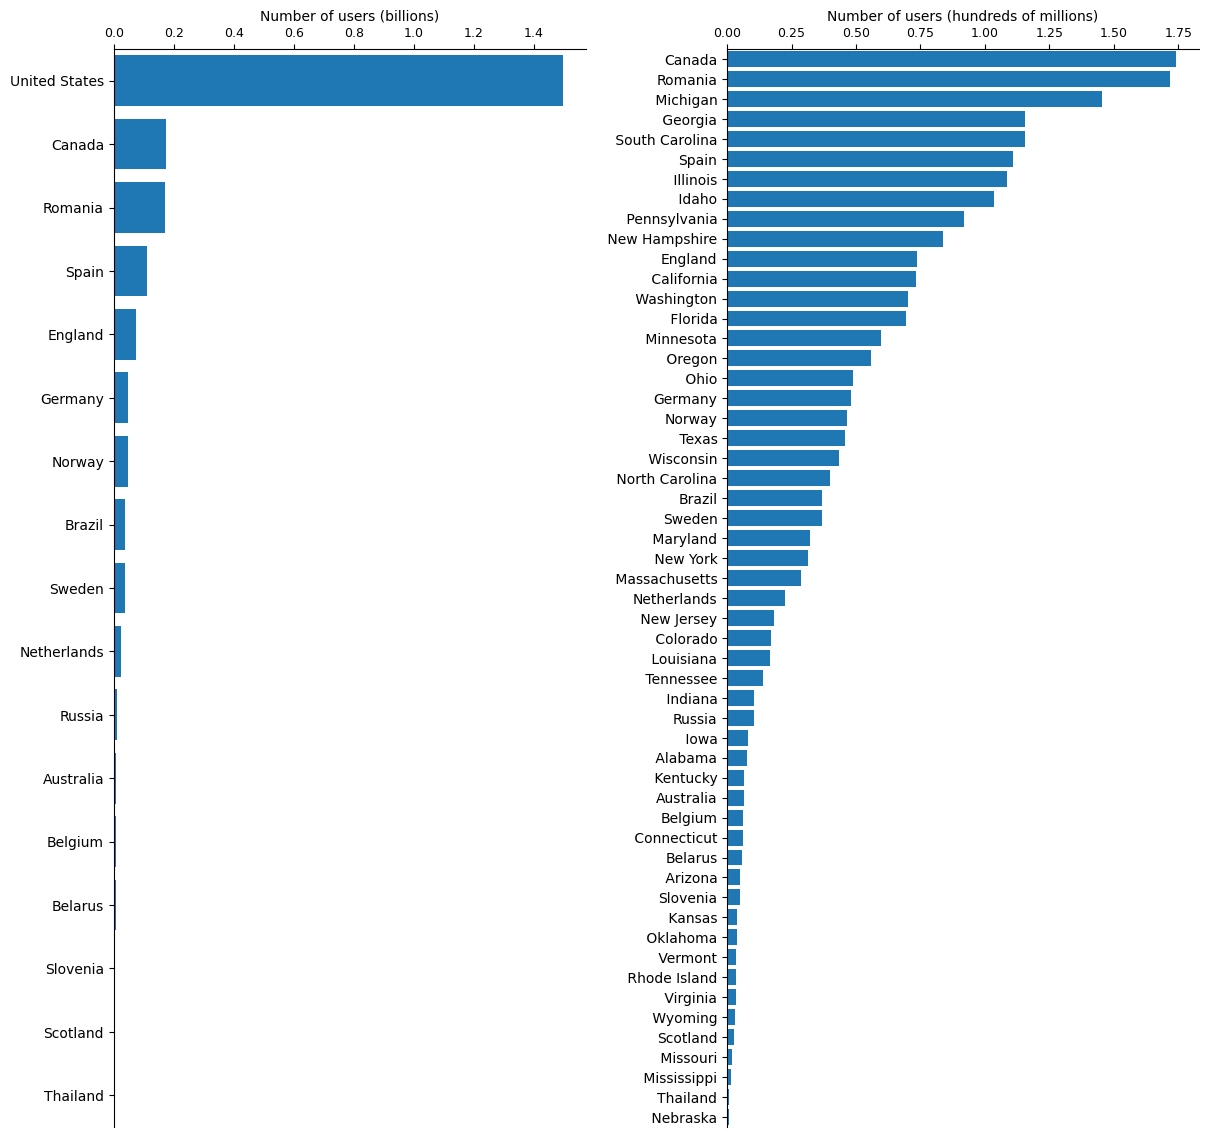

In [39]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,14), sharey=False, gridspec_kw={'wspace': 0.3})

axs[0].barh(count_country_pop_order.Location, count_country_pop_order['user_id.1'])
axs[1].barh(count_state_pop_order.location, count_state_pop_order['user_id.1'])
axs[0].tick_params(axis = 'x', labelsize= 9, bottom=False, labelbottom=False, top=True, labeltop=True)
axs[1].tick_params(axis = 'x', labelsize= 9, bottom=False, labelbottom=False, top=True, labeltop=True)
axs[0].xaxis.set_label_position('top')
axs[1].xaxis.set_label_position('top')
axs[0].xaxis.offsetText.set_visible(False)
axs[1].xaxis.offsetText.set_visible(False)


axs[0].spines['bottom'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['right'].set_visible(False)

axs[0].set_ylim(-0.5,len(count_country_pop_order.Location)-0.5)
axs[1].set_ylim(-0.5,len(count_state_pop_order.location)-0.5)
axs[0].set_xlabel('Number of users (billions)')
axs[1].set_xlabel('Number of users (hundreds of millions)')

plt.show()

# Beer styles per country
We would like to analyse the number of reviews per beer style per country

In [32]:
beer_dict = {
    'American Pale Ale': 'Pale Ale',
    'American Blonde Ale': 'Pale Ale',
    'Golden Ale/Blond Ale': 'Pale Ale',
    'Bitter': 'Pale Ale',
    'Pale Ale': 'Pale Ale',
    'American Pale Ale (APA)': 'Pale Ale',
    'English Pale Ale': 'Pale Ale',
    'English Bitter': 'Pale Ale',
    'Premium Bitter/ESB': 'Pale Ale',
    'English India Pale Ale (IPA)': 'Pale Ale',
    'Extra Special / Strong Bitter (ESB)': 'Pale Ale',
    'Saison / Farmhouse Ale': 'Pale Ale',
    'English Pale Mild Ale': 'Pale Ale',
    'Saison': 'Pale Ale',
    'Belgian Pale Ale': 'Pale Ale',
    'Belgian Strong Pale Ale': 'Strong Pale Ale',
    'Tripel': 'Strong Pale Ale',
    'Abbey Tripel': 'Strong Pale Ale',
    'American IPA': 'IPA',
    'Black IPA': 'IPA',
    'India Pale Ale (IPA)': 'IPA',
    'American Double / Imperial IPA': 'IPA',
    'Imperial IPA': 'IPA',
    'New England IPA (NEIPA)': 'IPA',
    'Session IPA': 'IPA',
    'Belgian IPA': 'IPA',
    'Abbey Dubbel': 'Brown/Dark Ale',
    'Dubbel': 'Brown/Dark Ale',
    'Belgian Dark Ale': 'Brown/Dark Ale',
    'American Brown Ale': 'Brown/Dark Ale',
    'Brown Ale': 'Brown/Dark Ale',
    'English Dark Mild Ale': 'Brown/Dark Ale',
    'American Black Ale': 'Brown/Dark Ale',
    'English Brown Ale': 'Brown/Dark Ale',
    'Belgian Strong Dark Ale': 'Strong Brown/Dark Ale',
    'Abt/Quadrupel': 'Strong Brown/Dark Ale',
    'Barley Wine': 'Strong Brown/Dark Ale',
    'English Barleywine': 'Strong Brown/Dark Ale',
    'American Barleywine': 'Strong Brown/Dark Ale',
    'Quadrupel (Quad)': 'Strong Brown/Dark Ale',
    'Amber Ale': 'Amber Ale',
    'American Amber Ale': 'Amber Ale',
    'Irish Red Ale': 'Amber Ale',
    'American Amber / Red Ale': 'Amber Ale',
    'Red Ale': 'Amber Ale',
    'Belgian Ale': 'Ale',
    'Irish Ale': 'Ale',
    'Old Ale': 'Ale',
    'Mild Ale': 'Ale',
    'Traditional Ale': 'Ale',
    'Scotch Ale / Wee Heavy': 'Ale',
    'Scotch Ale': 'Ale',
    'Scottish Ale': 'Ale',
    'Belgian Strong Ale': 'Strong Ale',
    'American Strong Ale': 'Strong Ale',
    'English Strong Ale': 'Strong Ale',
    'Winter Warmer': 'Strong Ale',
    'Stout': 'Stout',
    'American Stout': 'Stout',
    'Dry Stout': 'Stout',
    'American Double / Imperial Stout': 'Stout',
    'English Stout': 'Stout',
    'Imperial Stout': 'Stout',
    'Irish Dry Stout': 'Stout',
    'Foreign / Export Stout': 'Stout',
    'Oatmeal Stout': 'Stout',
    'Russian Imperial Stout': 'Stout',
    'Milk / Sweet Stout': 'Stout',
    'Foreign Stout': 'Stout',
    'Sweet Stout': 'Stout',
    'Porter': 'Porter',
    'American Porter': 'Porter',
    'Baltic Porter': 'Porter',
    'Imperial Porter': 'Porter',
    'English Porter': 'Porter',
    'American Dark Wheat Ale': 'Wheat Beer',
    'Berliner Weissbier': 'Wheat Beer',
    'Dunkelweizen': 'Wheat Beer',
    'German Hefeweizen': 'Wheat Beer',
    'Hefeweizen': 'Wheat Beer',
    'Wheat Ale': 'Wheat Beer',
    'Weizen Bock': 'Wheat Beer',
    'Roggenbier': 'Wheat Beer',
    'Weizenbock': 'Wheat Beer',
    'Witbier': 'Wheat Beer',
    'German Kristallweizen': 'Wheat Beer',
    'Berliner Weisse': 'Wheat Beer',
    'Kristalweizen': 'Wheat Beer',
    'Wheatwine': 'Wheat Beer',
    'Dunkelweizen': 'Wheat Beer',
    'American Pale Wheat Ale': 'Wheat Beer',
    'Flanders Oud Bruin': 'Wild/Sour Beer',
    'Flanders Red Ale': 'Wild/Sour Beer',
    'Gose': 'Wild/Sour Beer',
    'Lambic - Fruit': 'Wild/Sour Beer',
    'American Wild Ale': 'Wild/Sour Beer',
    'Lambic - Unblended': 'Wild/Sour Beer',
    'Lambic Style - Faro': 'Wild/Sour Beer',
    'Lambic Style - Fruit': 'Wild/Sour Beer',
    'Lambic Style - Gueuze': 'Wild/Sour Beer',
    'Lambic Style - Unblended': 'Wild/Sour Beer',
    'Sour Red/Brown': 'Wild/Sour Beer',
    'Sour/Wild Ale': 'Wild/Sour Beer',
    'Faro': 'Wild/Sour Beer',
    'Gueuze': 'Wild/Sour Beer',
    'Grodziskie/Gose/Lichtenhainer': 'Wild/Sour Beer',
    'American Adjunct Lager': 'Pilsner & Pale Lager',
    'American Pale Lager': 'Pilsner & Pale Lager',
    'Pilsener': 'Pilsner & Pale Lager',
    'Dortmunder / Export Lager': 'Pilsner & Pale Lager',
    'European Pale Lager': 'Pilsner & Pale Lager',
    'German Pilsener': 'Pilsner & Pale Lager',
    'Pale Lager': 'Pilsner & Pale Lager',
    'Munich Helles Lager': 'Pilsner & Pale Lager',
    'Pilsener (German and Czech)': 'Pilsner & Pale Lager',
    'Czech Pilsener': 'Pilsner & Pale Lager',
    'Czech Pilsner (Světlý)': 'Pilsner & Pale Lager',
    'India Style Lager': 'Pilsner & Pale Lager',
    'Imperial Pils/Strong Pale Lager': 'Pilsner & Pale Lager',
    'Kellerbier / Zwickelbier': 'Pilsner & Pale Lager',
    'Euro Pale Lager': 'Pilsner & Pale Lager',
    'Zwickel/Keller/Landbier': 'Pilsner & Pale Lager',
    'Euro Strong Lager': 'Pilsner & Pale Lager',
    'American Double / Imperial Pilsner': 'Pilsner & Pale Lager',
    'Light Lager': 'Pilsner & Pale Lager',
    'Radler/Shandy': 'Pilsner & Pale Lager',
    'Japanese Rice Lager': 'Pilsner & Pale Lager',
    'Premium Lager': 'Pilsner & Pale Lager',
    'Dortmunder/Helles': 'Pilsner & Pale Lager',
    'Doppelbock': 'Bock',
    'Eisbock': 'Bock',
    'Heller Bock': 'Bock',
    'Maibock / Helles Bock': 'Bock',
    'Bock': 'Bock',
    'Amber Lager/Vienna': 'Dark Lager',
    'Munich Dunkel Lager': 'Dark Lager',
    'Schwarzbier': 'Dark Lager',
    'Vienna Lager': 'Dark Lager',
    'American Amber / Red Lager': 'Dark Lager',
    'Dunkel/Tmavý': 'Dark Lager',
    'Dunkler Bock': 'Dark Lager',
    'Euro Dark Lager': 'Dark Lager',
    'Schwarzbier': 'Dark Lager',
    'Polotmavý': 'Dark Lager',
    'Märzen / Oktoberfest': 'Dark Lager',
    'Oktoberfest/Märzen': 'Dark Lager',
    'Rauchbier': 'Smoked',
    'Smoked': 'Smoked',
    'Smoked Beer': 'Smoked',
    'Cream Ale': 'Hybrid Beer',
    'Kölsch': 'Hybrid Beer',
    'California Common': 'Hybrid Beer',
    'California Common / Steam Beer': 'Hybrid Beer',
    'Braggot': 'Hybrid Beer',
    'Bière de Garde': 'Hybrid Beer',
    'Black & Tan': 'Hybrid Beer',
    'Altbier': 'Hybrid Beer',
    'Rye Beer': 'Hybrid Beer',
    'Chile Beer': 'Herbs/Vegetables',
    'Cider': 'Herbs/Vegetables',
    'Fruit / Vegetable Beer': 'Herbs/Vegetables',
    'Fruit Beer': 'Herbs/Vegetables',
    'Herbed / Spiced Beer': 'Herbs/Vegetables',
    'Mead': 'Herbs/Vegetables',
    'Spice/Herb/Vegetable': 'Herbs/Vegetables',
    'Specialty Grain': 'Herbs/Vegetables',
    'Sahti': 'Herbs/Vegetables',
    'Sahti/Gotlandsdricke/Koduõlu': 'Herbs/Vegetables',
    'Scottish Gruit / Ancient Herbed Ale': 'Herbs/Vegetables',
    'Pumpkin Ale': 'Herbs/Vegetables',
    'Perry': 'Herbs/Vegetables',
    'Happoshu': 'Low Alcohol',
    'Low Alcohol': 'Low Alcohol',
    'Low Alcohol Beer': 'Low Alcohol',
    'Kvass': 'Low Alcohol',
    'American Malt Liquor': 'Cocktails',
    'Bière de Champagne / Bière Brut': 'Cocktails',
    'Malt Liquor': 'Cocktails',
    'Saké - Daiginjo': 'Cocktails',
    'Saké - Futsu-shu': 'Cocktails',
    'Saké - Genshu': 'Cocktails',
    'Saké - Ginjo': 'Cocktails',
    'Saké - Honjozo': 'Cocktails',
    'Saké - Infused': 'Cocktails',
    'Saké - Junmai': 'Cocktails',
    'Saké - Koshu': 'Cocktails',
    'Saké - Namasaké': 'Cocktails',
    'Saké - Nigori': 'Cocktails',
    'Saké - Taru': 'Cocktails',
    'Saké - Tokubetsu': 'Cocktails'
}

In [33]:
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

In [37]:
unified_users['expertise'] = (unified_users['total_nbr_ratings'] >= 3352).astype(int)

In [38]:
unified_ratings['categories'] = unified_ratings['style'].str.strip().map(beer_dict)

In [39]:
pd.unique(unified_ratings[unified_ratings['categories'].isnull()]['style'])

array([], dtype=object)

In [40]:
equivalent_expertise = dict(zip(unified_users['user_id'], unified_users['expertise']))
unified_ratings['expertise']=unified_ratings['user_id'].map(equivalent_expertise)
unified_ratings

,beer_name,beer_id,brewery_name,brewery_id,style,date,rating,user_id,Procedence,country_user,country_brewery,year,Season,z_score,exp_mean,diff_exp_mean,ith_rating,detrend,categories,expertise
0,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2003-10-15 10:00:00,3.55,11266.0,BA,"United States, Illinois","United States, Louisiana",2003,Autumn,-0.201923,-0.201923,0.000000,1,-0.032678,Bock,0.0
1,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2003-12-22 11:00:00,3.85,6816.0,BA,"United States, Massachusetts","United States, Louisiana",2003,Winter,0.228929,0.013503,0.215426,2,0.397968,Bock,0.0
2,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-04-06 10:00:00,2.90,5470.0,BA,"United States, Louisiana","United States, Louisiana",2004,Spring,-1.253651,-0.408882,-0.844769,3,-1.084818,Bock,0.0
3,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-04-22 10:00:00,2.39,5545.0,BA,"United States, Connecticut","United States, Louisiana",2004,Spring,-2.019939,-0.811646,-1.208293,4,-1.851312,Bock,0.0
4,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-05-02 10:00:00,3.28,32532.0,BA,"United States, Texas","United States, Louisiana",2004,Spring,-0.682692,-0.785855,0.103163,5,-0.514270,Bock,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15515101,Black Sheep 54 Degrees North,536472.0,Black Sheep,48.0,Pilsener,2017-07-25 10:00:00,2.50,357380.0,RB,England,England,2017,Summer,-1.528356,-1.528356,0.000000,1,-1.528356,Pilsner & Pale Lager,0.0
15515102,Carling Black Fruits Cider,536473.0,Molson Coors UK &#40;MolsonCoors&#41;,26.0,Cider,2017-07-25 10:00:00,1.80,420333.0,RB,England,England,2017,Summer,-2.709121,-2.709121,0.000000,1,-2.709121,Herbs/Vegetables,0.0
15515103,Brockley Lager,536474.0,Brockley Brewery,16390.0,Pilsener,2017-07-03 10:00:00,3.60,85632.0,RB,England,England,2017,Summer,0.327132,0.327132,0.000000,1,0.327132,Pilsner & Pale Lager,0.0
15515104,Brockley IPA,536475.0,Brockley Brewery,16390.0,India Pale Ale (IPA),2017-07-27 10:00:00,2.80,107993.0,RB,England,England,2017,Summer,-1.022314,-1.022314,0.000000,1,-1.022314,IPA,1.0


In [52]:
def weighted_average(group):
    # Define weights based on 'expertise'
    weights = {1: 1.5, 0: 1}

    # Calculate the weighted average
    weighted_avg = (group['detrend'] * group['expertise'].map(weights)).sum() / group['expertise'].map(weights).sum()

    return pd.Series({'categories': group['categories'].iloc[0], 'country_user': group['country_user'].iloc[0], 'final_score': weighted_avg})

weighted_scores = unified_ratings.groupby(['country_user', 'categories'], as_index=False).apply(weighted_average)
weighted_scores = weighted_scores.sort_values(by=['country_user', 'final_score'],  ascending=[True, False])
weighted_scores

,categories,country_user,final_score
3,Strong Brown/Dark Ale,Abkhazia,2.512559
2,Porter,Abkhazia,2.287375
0,Herbs/Vegetables,Abkhazia,-1.585662
4,Wheat Beer,Abkhazia,-3.644316
1,Pilsner & Pale Lager,Abkhazia,-4.083522
...,...,...,...
3428,Pilsner & Pale Lager,Zambia,2.505872
3429,Wheat Beer,Zambia,0.924626
3430,Cocktails,Zimbabwe,2.836824
3432,Porter,Zimbabwe,0.864434


In [57]:
reviews_country= pd.crosstab(weighted_scores['country_user'], weighted_scores['categories'], 
                             values = weighted_scores['final_score'], aggfunc='mean')
reviews_country = reviews_country.fillna(0)
reviews_country

categories,Ale,Amber Ale,Bock,Brown/Dark Ale,Cocktails,Dark Lager,Herbs/Vegetables,Hybrid Beer,IPA,Low Alcohol,Pale Ale,Pilsner & Pale Lager,Porter,Smoked,Stout,Strong Ale,Strong Brown/Dark Ale,Strong Pale Ale,Wheat Beer,Wild/Sour Beer
country_user,,,,,,,,,,,,,,,,,,,,
Abkhazia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.585662,0.000000,0.000000,0.000000,0.000000,-4.083522,2.287375,0.000000,0.000000,0.000000,2.512559,0.000000,-3.644316,0.000000
Afghanistan,0.000000,0.000000,1.872730,0.000000,0.000000,1.183098,0.000000,0.000000,0.183125,0.000000,0.000000,-0.913074,-0.475788,0.000000,0.125420,0.740020,0.822391,0.000000,0.000000,0.000000
Albania,0.000000,0.000000,0.000000,0.000000,0.000000,-2.479944,0.000000,2.344122,1.141325,0.000000,0.000000,-1.240907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.938541,0.000000
Algeria,-1.145204,0.130976,-0.109775,0.000000,-3.120224,-1.096177,-2.352051,0.000000,-2.414818,0.000000,-1.593615,-1.820773,-0.539339,-0.087770,0.227094,-1.689915,0.000000,0.000000,0.101139,-1.810890
American Samoa,-1.637449,-3.057658,0.000000,-0.115087,0.000000,-0.929031,-0.445264,0.000000,1.108131,0.000000,0.351266,0.974173,0.726102,0.000000,-1.050334,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virgin Islands (U.S.),0.000000,0.970196,0.000000,1.130262,0.000000,0.709079,0.995850,0.000000,0.000000,0.000000,-0.259930,-0.059507,2.695716,1.039649,0.266821,1.204539,0.747535,1.817846,0.583820,0.000000
Wales,-0.044291,0.093293,-0.615702,0.285124,0.000000,-0.322741,-0.577036,0.095511,0.375558,-2.466418,-0.441800,-1.005556,0.336216,0.243564,0.274072,0.157072,0.517980,0.522301,-0.122817,0.577387
Yemen,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.848283,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.901971,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
search_word = 'United States'
vector = reviews_country.index.values

occurrences_usa = [word for word in vector if search_word in word]

usa_df = pd.DataFrame(reviews_country[reviews_country.index.isin(occurrences_usa)].apply(lambda x: np.mean(x), axis = 0)).T
usa_df = usa_df.rename(index = {0:'United States of America'})
usa_df

categories,Ale,Amber Ale,Bock,Brown/Dark Ale,Cocktails,Dark Lager,Herbs/Vegetables,Hybrid Beer,IPA,Low Alcohol,Pale Ale,Pilsner & Pale Lager,Porter,Smoked,Stout,Strong Ale,Strong Brown/Dark Ale,Strong Pale Ale,Wheat Beer,Wild/Sour Beer
United States of America,0.103542,-0.33647,-0.065298,-0.096558,-2.121368,-0.352133,-0.45618,-0.325421,0.191869,-2.314036,-0.170385,-1.2013,0.134938,0.049978,0.39534,0.337809,0.384441,0.158927,-0.246318,0.39695


In [59]:
search_word = ['Wales', 'Scotland', 'Northern Ireland', 'England']

occurrences_gb = [word for word in vector if word in search_word]
GB_df = pd.DataFrame(reviews_country[reviews_country.index.isin(occurrences_gb)].apply(lambda x: np.mean(x), axis = 0)).T
GB_df = GB_df.rename(index = {0:'United Kingdom of Great Britain and Northern Ireland'})
GB_df

categories,Ale,Amber Ale,Bock,Brown/Dark Ale,Cocktails,Dark Lager,Herbs/Vegetables,Hybrid Beer,IPA,Low Alcohol,Pale Ale,Pilsner & Pale Lager,Porter,Smoked,Stout,Strong Ale,Strong Brown/Dark Ale,Strong Pale Ale,Wheat Beer,Wild/Sour Beer
United Kingdom of Great Britain and Northern Ireland,-0.035806,-0.116958,-0.169901,0.039669,-0.79557,-0.34306,-0.337732,-0.205587,0.29241,-1.358242,-0.269071,-0.979853,0.254969,0.203364,0.366655,0.146259,0.398419,0.252913,-0.092699,0.379972


In [60]:
reviews_country = pd.concat([reviews_country, usa_df, GB_df])
reviews_country

categories,Ale,Amber Ale,Bock,Brown/Dark Ale,Cocktails,Dark Lager,Herbs/Vegetables,Hybrid Beer,IPA,Low Alcohol,Pale Ale,Pilsner & Pale Lager,Porter,Smoked,Stout,Strong Ale,Strong Brown/Dark Ale,Strong Pale Ale,Wheat Beer,Wild/Sour Beer
Abkhazia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.585662,0.000000,0.000000,0.000000,0.000000,-4.083522,2.287375,0.000000,0.000000,0.000000,2.512559,0.000000,-3.644316,0.000000
Afghanistan,0.000000,0.000000,1.872730,0.000000,0.000000,1.183098,0.000000,0.000000,0.183125,0.000000,0.000000,-0.913074,-0.475788,0.000000,0.125420,0.740020,0.822391,0.000000,0.000000,0.000000
Albania,0.000000,0.000000,0.000000,0.000000,0.000000,-2.479944,0.000000,2.344122,1.141325,0.000000,0.000000,-1.240907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.938541,0.000000
Algeria,-1.145204,0.130976,-0.109775,0.000000,-3.120224,-1.096177,-2.352051,0.000000,-2.414818,0.000000,-1.593615,-1.820773,-0.539339,-0.087770,0.227094,-1.689915,0.000000,0.000000,0.101139,-1.810890
American Samoa,-1.637449,-3.057658,0.000000,-0.115087,0.000000,-0.929031,-0.445264,0.000000,1.108131,0.000000,0.351266,0.974173,0.726102,0.000000,-1.050334,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yemen,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.848283,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.901971,0.000000,0.000000,0.000000,0.000000,0.000000
Zambia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.505872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.924626,0.000000
Zimbabwe,0.000000,0.000000,0.000000,0.000000,2.836824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.724133,0.864434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
United States of America,0.103542,-0.336470,-0.065298,-0.096558,-2.121368,-0.352133,-0.456180,-0.325421,0.191869,-2.314036,-0.170385,-1.201300,0.134938,0.049978,0.395340,0.337809,0.384441,0.158927,-0.246318,0.396950


In [61]:
#Interactive plot
app = Dash(__name__)


app.layout = html.Div([
    html.H4('Beer categories'),
    dcc.Graph(id="graph"),
    html.P("Countries:"),
    dcc.Dropdown(id='names',
        options=reviews_country.T.columns.values,
        value='Switzerland', clearable=False
    ),
])


@app.callback(
    Output("graph", "figure"), 
    Input("names", "value"))
def generate_chart(names):
    df = reviews_country.T # replace with your own data source
    fig = px.pie(df, values= names , names= reviews_country.T.index.values , hole=.3)
    fig.update_traces(textposition = 'inside')
    return fig


app.run_server(debug=True)

In [62]:
top_beers = pd.DataFrame(reviews_country.idxmax(axis = 1), columns=['top_1'])
top_beers = top_beers.reset_index()
top_beers = top_beers.rename(columns = {'index':'country'})
top_beers


,country,top_1
0,Abkhazia,Strong Brown/Dark Ale
1,Afghanistan,Bock
2,Albania,Hybrid Beer
3,Algeria,Stout
4,American Samoa,IPA
...,...,...
247,Yemen,Ale
248,Zambia,Pilsner & Pale Lager
249,Zimbabwe,Cocktails
250,United States of America,Wild/Sour Beer


In [63]:
iso_alpha = pd.read_csv('iso_alpha_countries.csv')
iso_alpha = iso_alpha[['name', 'alpha-3']]
iso_alpha = iso_alpha.rename(columns = {'name':'country', 'alpha-3':'iso_alpha'})

merged = top_beers.merge(iso_alpha, on = 'country')

merged

,country,top_1,iso_alpha
0,Afghanistan,Bock,AFG
1,Albania,Hybrid Beer,ALB
2,Algeria,Stout,DZA
3,American Samoa,IPA,ASM
4,Andorra,Strong Brown/Dark Ale,AND
...,...,...,...
155,Yemen,Ale,YEM
156,Zambia,Pilsner & Pale Lager,ZMB
157,Zimbabwe,Cocktails,ZWE
158,United States of America,Wild/Sour Beer,USA


In [64]:
m_countries = merged['country'].values
t_countries = top_beers['country'].values

difference = list(set(t_countries) - set(m_countries))

occurrences = (occurrences_usa + occurrences_gb)
#We remove the USA and great britain
filtered_vector = [word for word in difference if word not in occurrences]

#missing_df = top_beers[top_beers['country'].isin(filtered_vector)]

In [65]:
missing_iso = pd.read_csv('missing_iso_alpha.csv')
merged =pd.concat([merged, missing_iso])
merged

,country,top_1,iso_alpha
0,Afghanistan,Bock,AFG
1,Albania,Hybrid Beer,ALB
2,Algeria,Stout,DZA
3,American Samoa,IPA,ASM
4,Andorra,Strong Brown/Dark Ale,AND
...,...,...,...
33,Tanzania,Pilsner & Pale Lager,TZA
34,Tibet,Strong Brown/Dark Ale,NaN
35,Vatican City,Pale Ale,VAT
36,Venezuela,Pilsner & Pale Lager,VEN


In [66]:
difference = list(set(top_beers['country'].values) - set(merged['country'].values))
difference

['United States, Minnesota',
 'United States, Arizona',
 'United States, Louisiana',
 'United States, South Dakota',
 'United States, Maryland',
 'United States, Pennsylvania',
 'United States, Massachusetts',
 'United States, Georgia',
 'United States, Michigan',
 'United States, Kansas',
 'United States, New Jersey',
 'United States, North Dakota',
 'England',
 'United States, Arkansas',
 'Northern Ireland',
 'United States, West Virginia',
 'United States, New Hampshire',
 'United States, Utah',
 'United States, Delaware',
 'United States, Wisconsin',
 'United States, Hawaii',
 'United States, Mississippi',
 'United States, New York',
 'United States, Iowa',
 'United States, Rhode Island',
 'United States, Connecticut',
 'United States, South Carolina',
 'United States, Montana',
 'United States, Wyoming',
 'United States, Texas',
 'United States, Colorado',
 'Wales',
 'United States, Vermont',
 'United States, Kentucky',
 'United States, Ohio',
 'United States, Idaho',
 'United Sta

In [68]:
df = px.data.gapminder().query("year==2007")

fig = px.choropleth(merged, locations="iso_alpha", 
                    color="top_1", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale= sns.color_palette('rocket', 20)) #Color
fig.show()

#px.colors.sequential.Plasma

In [ ]:
#Now lets do a interactive plot where we can select the country of interest:


# Matching users by styles ratings 

As we are focusing on the preferences on the style of beers, we consider that the user that did a review in the two different websites, these are different users

In [40]:
#Merge RB and BA ratings
total_MB_ratings = pd.concat([MB_ratings_BA, MB_ratings_RB])
total_MB_ratings.shape

(1976589, 23)

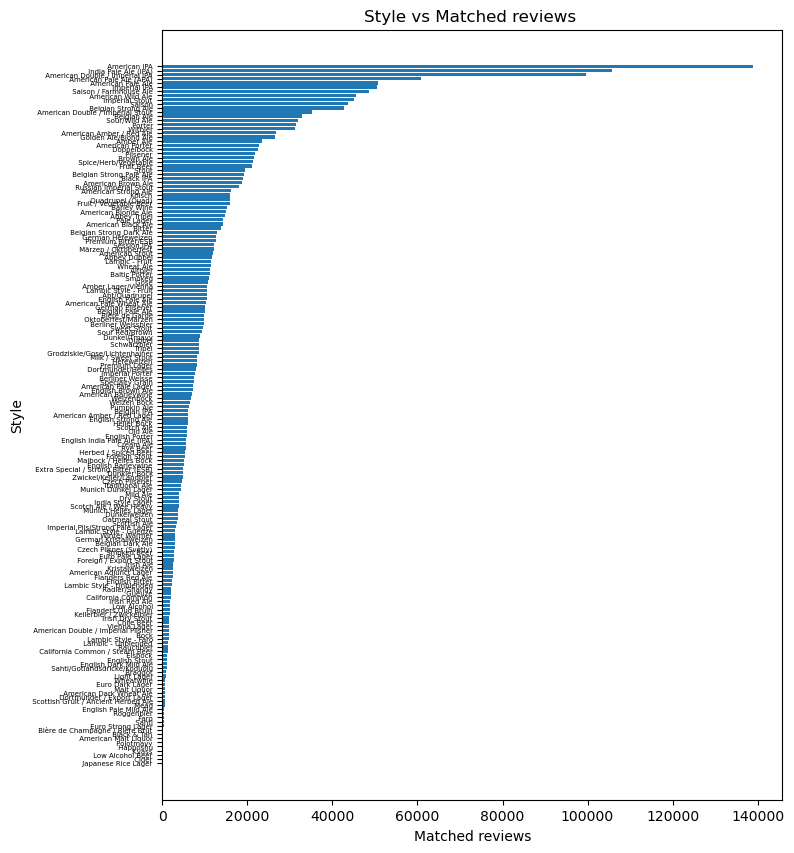

In [41]:
#Here we will see how is the distribution of the different beers

value_counts = total_MB_ratings['style'].value_counts()

fig, ax = plt.subplots( figsize = (8,10))
ax.barh(value_counts.index, value_counts)

# Set labels and title
ax.set_xlabel('Matched reviews')
ax.set_ylabel('Style')
ax.set_title('Style vs Matched reviews ')
ax.tick_params(axis = 'x', labelsize = 10)
ax.tick_params(axis = 'y', labelsize = 5)

# Rotate the entire plot by 90 degrees
plt.gca().invert_yaxis()  # Invert y-axis to make the plot more readable
plt.show()

In [42]:
value_counts[0:10]
#We can see that just in the top 10, there are multiple styles of IPA and Pale Ale that could be somehow grouped

style
 American IPA                      138888
 India Pale Ale (IPA)              105718
 American Double / Imperial IPA     99624
 American Pale Ale (APA)            60756
 American Pale Ale                  50816
 Imperial IPA                       50426
 Saison / Farmhouse Ale             48516
 American Wild Ale                  45615
 Imperial Stout                     44974
 Saison                             43723
Name: count, dtype: int64

In [43]:
style_pref_merged = pd.crosstab(total_MB_ratings['user_id'].values, total_MB_ratings['style'].values, 
                                values = total_MB_ratings['detrend'].values, aggfunc='mean')

style_pref_merged = style_pref_merged.T.fillna(0)

In [44]:
from scipy.stats import pearsonr

#pearson_matrix = style_pref_merged.corr(numeric_only= True)

$$r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2 \sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

With:

 $ r $  the Pearson correlation coefficient
 
 $ n $ the number of data points
 
 $ x_i $ and $y_i$ the individual data points

 $\bar{x}$ and $\bar{y}$ the mean values

Pearson_matrix will give a matrix of size 92113x92113 which is too big, and therefore is computationally complex. For tackling this problem
We thougth on calculating the pearson coefficient per column pairwise and then just keep the maximum value after a defined threshold.

Another idea is to find a better classifier for the styles, either by grouping manually by the type independent of the country and
 subtypes of the style or to apply a ML algorithm for an optimized clustering

# Breweries analysis

In [45]:
# Filter the datasets and remove breweries for which the number of beers associated to them is zero
BA_breweries_filt = BA_breweries[BA_breweries['nbr_beers']>=1].copy(deep=True)
RB_breweries_filt = RB_breweries[RB_breweries['nbr_beers']>=1].copy(deep=True)
MB_breweries_filt = MB_breweries[(MB_breweries['nbr_beers']>=1) & (MB_breweries['nbr_beers.1']>=1)].copy(deep=True)

In [46]:
# Explore properties in each filtered dataset
print('Number of breweries in BA dataset is: {}, and number of unique locations among all breweries is: {}'.format(BA_breweries_filt.shape[0], BA_breweries_filt.location.nunique()))
print('Number of breweries in RB dataset is: {}, and number of unique locations among all breweries is: {}'.format(RB_breweries_filt.shape[0], RB_breweries_filt.location.nunique()))
print('Number of breweries in MB dataset is: {}, and number of unique locations among all breweries is: {}'.format(MB_breweries_filt.shape[0], MB_breweries_filt.location.nunique()))

Number of breweries in BA dataset is: 14522, and number of unique locations among all breweries is: 277
Number of breweries in RB dataset is: 24118, and number of unique locations among all breweries is: 267
Number of breweries in MB dataset is: 7600, and number of unique locations among all breweries is: 202


The two previous chuncks of code shows that the MB dataset has a lower number of breweries compared to the BA and RB datasets. If we want to provide information on as many breweries as possible, we will need to compute the union between the BA and RB datasets. This could be done on the brewery names, adjusting for changes in the naming.

In [47]:
MB_breweries.head()

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.431275,0.889062
1,32848,Northern Ireland,The Sheelin Brewery,4,17616,Northern Ireland,Sheelin,2,0.526388,0.863596
2,40360,Northern Ireland,Walled City Brewing Company,6,24866,Northern Ireland,Walled City,3,0.527852,0.954183
3,40309,Northern Ireland,Ards Brewing Company,7,13538,Northern Ireland,Ards Brewing Co.,13,0.554395,0.896098
4,41205,Northern Ireland,Barrahooley Brewery,3,22304,Northern Ireland,Barrahooley Craft Brewery,4,0.602544,0.896205


On the MB dataset one can observe that the nbr_beer differs sometimes between the RB and BA datasets. For breweries present in both datasets and having different number of beers associated with them, we will consider the higher number. 

In [48]:
BA_breweries_filt['nbr_beers'].describe()

count    14522.000000
mean        24.298444
std         74.041044
min          1.000000
25%          3.000000
50%          8.000000
75%         21.000000
max       1196.000000
Name: nbr_beers, dtype: float64

In [49]:
RB_breweries_filt['nbr_beers'].describe()

count    24118.000000
mean        19.078655
std         31.572100
min          1.000000
25%          3.000000
50%          8.000000
75%         20.000000
max        295.000000
Name: nbr_beers, dtype: float64

The previous two chuncks of code show that the mean values are higher than the median in both datasets, indicating that the distribution of number of beers in breweries is highly skewed. 

In [50]:
print('Number of unique locations in the BA dataset if we select breweries that produce maximum 8 types of beers is: {}'. format(BA_breweries_filt[(BA_breweries_filt['nbr_beers']<=8)].location.nunique()))
print('Number of unique locations in the RB dataset if we select breweries that produce maximum 8 types of beers is: {}'. format(RB_breweries_filt[(RB_breweries_filt['nbr_beers']<=8)].location.nunique()))

Number of unique locations in the BA dataset if we select breweries that produce maximum 8 types of beers is: 260
Number of unique locations in the RB dataset if we select breweries that produce maximum 8 types of beers is: 259


We can see that if we perform a hard filtering on both dataset, by selecting breweries that produce a maximum of 8 types of beer, then we will recover almost all locations present in both datasets.
Our goal is to select breweries with the 'local' connotation. Our intepretation here is that in industrial breweries, meaning breweries producing a large number of beers (for instance more than 100), the beers are probably accessible to broad market that could even include a set of countries. While breweries that have a small number of beers associated to them, could probably be more 'local' and only know within a country. 
In this analysis, we will make the assumption that the number of beers associated with a brewery correspond to the real number of beers produced by that brewery

In [51]:
BA_breweries_subst = BA_breweries_filt[BA_breweries_filt['nbr_beers'] <= 8].copy(deep=True)
RB_breweries_subst = RB_breweries_filt[RB_breweries_filt['nbr_beers'] <= 8].copy(deep=True)

In [52]:
# Filtering beers datasets for beers belonging to the microbreweries (breweries producing max 8 beers) subset before
BA_craft_beers = BA_beers[BA_beers['brewery_id'].isin(BA_breweries_subst['id'].to_list())]
RB_craft_beers = RB_beers[RB_beers['brewery_id'].isin(RB_breweries_subst['id'].to_list())]

# Text analysis

The rationale behind this section is to process the textual reviews given by the users in order to provide insight about:
- Clustering (section II of methods) of users to see if similar wording are used by users
- Fun facts (section III of methods) about the community to see if there is:
    - Decreasing length of the reviews over the years
    - Unusual words used when describing reviews with high ABV beers

We will start by selecting only english reviews (for reasons described) and pre-processing the reviews by using a python script. The next steps include the calculation of length and TF-IDF scores for each review. For the clustering task, from the TF-IDF we will extrapolate words that best define each reviewers. For the fun facts section, we will use TF-IDF to identify unusual words and use SVD decomposition to reduce dimensionality of the reviews and represent them into vectorial space. By color coding each review by corresponding ABV content we can see if there's any relation between the ABV and the unusual words used by reviewers.

\begin{equation*}
 \text{TF}(t, d) = \frac{count(t)}{count(g)} \qquad\qquad \text{IDF}(t) = \log{\frac{1+n}{1+df(t)}} + 1
\end{equation*}


\begin{equation*}
 \text{TF-IDF}(t,d) = \text{TF}(t, d) * \text{IDF}(t)
\end{equation*}

where:
- $t$ is the specific term in a document
- $g$ is the general token in a specific document
- $n$ is the total number of documents in the set
- $df(t)$ is the number of document term $t$ is present in


In [53]:
# Concatenating all informations for the text analysis
df_txt_analysis = pd.concat([MB_ratings_RB.copy(), MB_ratings_BA.copy()], ignore_index=True)

# Keeping only potentially informative columns for textual analysis and dropping missing values
df_txt_analysis = df_txt_analysis[['abv', 'beer_name', 'brewery_name', 'style', 'year', 'rating', 'user_name', 'detrend', 'text']]
df_txt_analysis.dropna(subset='text', inplace=True)
df_txt_analysis.head()

,abv,beer_name,brewery_name,style,year,rating,user_name,detrend,text
0,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2000,3.5,DJH-Bird99,0.078186,"Good beer, espacially when you put on DJ Alig..."
1,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.6,pauliefrog99,-0.668204,A little bit of caramel and malt flavor in th...
2,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.2,daviddeep99,-1.086552,I think this beer is made by thinning one par...
3,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.8,wodom1,-0.458480,This beer is actually 11.5%. 3 or 4 of them ...
4,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,3.0,JohnDo2000,-0.248976,"The beer is good, but it sure will knock you ..."


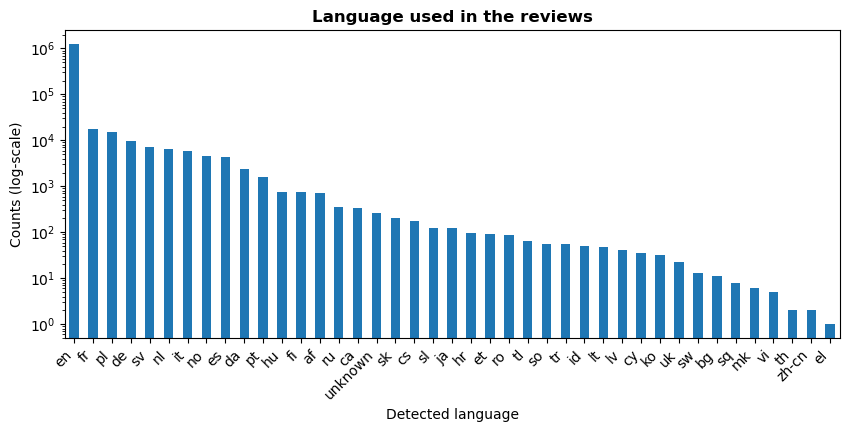

In [54]:
# The following cell (1/2) takes a long time to run. In case of need, we provide the tsv document generate at the following link:
# https://drive.google.com/drive/folders/17qaRlCumz7pfNYN_Wi0tANMIOS0jOUoB?usp=sharing
# It must be located in the MB_path folder

# Assigning language to the text analysis dataset 
df_txt_analysis = txt_pproc.adding_language(df_txt_analysis, MB_path)

# Plotting the language distributions for the text analysis dataset 
fig, ax = plt.subplots(figsize=(10,4))

language_counts = df_txt_analysis['language'].value_counts()
language_counts.plot(kind='bar')
plt.title('Language used in the reviews', weight='bold')
plt.xlabel('Detected language')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Counts (log-scale)')
plt.yscale('log')

plt.show()

Considering the distributions of languages detected we will filter the dataset only based on the English reviews. The reason of this choice comes from the need to find tune the parameters for each language during text pre-processing. Since English is the most common language among the reviews with 2 higher order of magnitude int counts we will only use English in the analysis.

In [55]:
# Keeping only english reviews
df_txt_analysis_en = df_txt_analysis[df_txt_analysis.language == 'en']
df_txt_analysis_en.head()

,abv,beer_name,brewery_name,style,year,rating,user_name,detrend,text,language
0,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2000,3.5,DJH-Bird99,0.078186,"Good beer, espacially when you put on DJ Alig...",en
1,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.6,pauliefrog99,-0.668204,A little bit of caramel and malt flavor in th...,en
2,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.2,daviddeep99,-1.086552,I think this beer is made by thinning one par...,en
3,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.8,wodom1,-0.458480,This beer is actually 11.5%. 3 or 4 of them ...,en
4,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,3.0,JohnDo2000,-0.248976,"The beer is good, but it sure will knock you ...",en


In [56]:
# The following cell (1/2) takes a long time to run. In case of need, we provide the tsv document generate at the following link:
# https://drive.google.com/drive/folders/17qaRlCumz7pfNYN_Wi0tANMIOS0jOUoB?usp=sharing
# It must be located in the MB_path folder

# Text preprocessing and dropping nan values that can arise from the processing
df_txt_processed = txt_pproc.cleaning(df_txt_analysis_en, MB_path)
df_txt_processed.dropna(subset=['text'], inplace=True)
df_txt_processed.head()

,abv,beer_name,brewery_name,style,year,rating,user_name,detrend,text,language,tokenize_text
0,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2000,3.5,DJH-Bird99,0.078186,good beer espacially put dj aligator whistle song,en,"['good', 'beer', 'espacially', 'put', 'dj', 'a..."
1,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.6,pauliefrog99,-0.668204,little bit caramel malt flavor way thin weak,en,"['little', 'bit', 'caramel', 'malt', 'flavor',..."
2,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.2,daviddeep99,-1.086552,think beer make thin one part anchor foghorn t...,en,"['think', 'beer', 'make', 'thin', 'one', 'part..."
3,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.8,wodom1,-0.458480,beer actually get hammer good beer look...,en,"['beer', 'actually', 'get', 'hammer', 'good', ..."
4,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,3.0,JohnDo2000,-0.248976,beer good sure knock ass tell bartender eight ...,en,"['beer', 'good', 'sure', 'knock', 'ass', 'tell..."


In [57]:
# Adding length of each review to the dataset
df_txt_processed['len'] = df_txt_processed['tokenize_text'].apply(lambda text: len(text))
df_txt_processed.head()

,abv,beer_name,brewery_name,style,year,rating,user_name,detrend,text,language,tokenize_text,len
0,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2000,3.5,DJH-Bird99,0.078186,good beer espacially put dj aligator whistle song,en,"['good', 'beer', 'espacially', 'put', 'dj', 'a...",74
1,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.6,pauliefrog99,-0.668204,little bit caramel malt flavor way thin weak,en,"['little', 'bit', 'caramel', 'malt', 'flavor',...",69
2,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.2,daviddeep99,-1.086552,think beer make thin one part anchor foghorn t...,en,"['think', 'beer', 'make', 'thin', 'one', 'part...",155
3,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.8,wodom1,-0.458480,beer actually get hammer good beer look...,en,"['beer', 'actually', 'get', 'hammer', 'good', ...",272
4,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,3.0,JohnDo2000,-0.248976,beer good sure knock ass tell bartender eight ...,en,"['beer', 'good', 'sure', 'knock', 'ass', 'tell...",369


In [58]:
# Computing TF-IDF matrix

tfidf_vec = TfidfVectorizer()
tfidf_mat = tfidf_vec.fit_transform(df_txt_processed['text'])

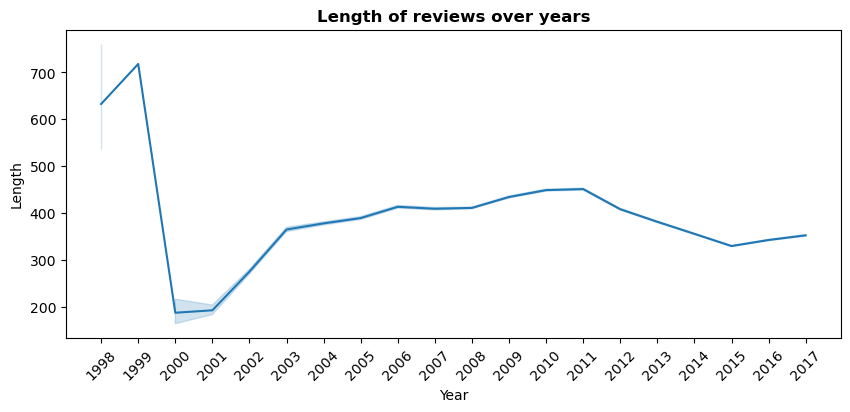

In [59]:
# Plotting the length of the reviews over years
fig, ax = plt.subplots(figsize=(10,4))

sns.lineplot(df_txt_processed, x='year', y='len')
plt.title('Length of reviews over years', weight='bold')
plt.xlabel('Year')
plt.xticks(np.unique(df_txt_processed.year), rotation=45)
plt.ylabel('Length')

plt.show()

Our hypothesis was that the lenght of reviews would decreased over year as we're living in a fast-paced world. We can observe this phenomenon in the decreased length of songs and possibility to speed up audio messages. Also the beer reviews seem to decrease in lenght over the years. However, this effect is only visible from 1998 to 2001 and then there's an increase with stable values. To further test our hypothesis (confirm or refuse) we have to look more into the data to disentagle other features (such as reviewer)  that could effect length of reviews.

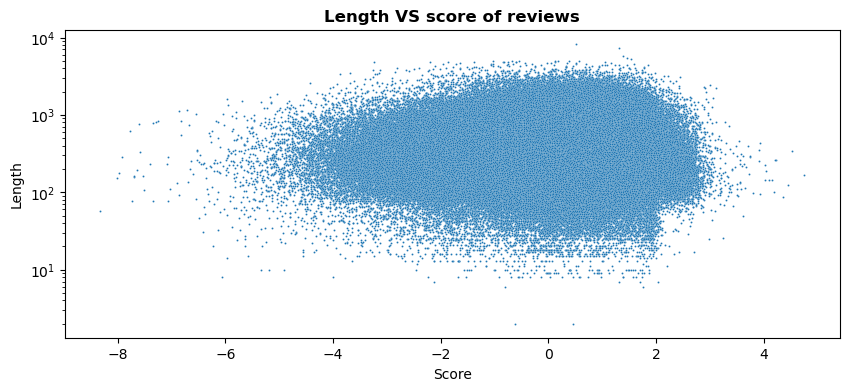

In [60]:
# Plotting the length and score of the reviews
fig, ax = plt.subplots(figsize=(10,4))

sns.scatterplot(data=df_txt_processed, x='detrend', y='len', s=2)
plt.title('Length VS score of reviews', weight='bold')
plt.xlabel('Score')
plt.ylabel('Length')
plt.yscale('log')

plt.show()

One of our hypothesis was that people that have bad experiences with beers would tend to write longer reviews to be more critic. Nevertheless, the just mentioned trend does not seem to appear as length and score seem not to be correlated